# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from sklearn.decomposition import PCA

- This script defines a function to draw ellipses for Gaussian Mixture Models (GMM) based on the covariance type of each component.
- It then applies GMM clustering to the California Housing dataset with scaled data and visualizes the results.
- Different GMM configurations are used for 'spherical', 'diag', 'tied', and 'full' covariance types.
- The script plots ellipses that represent the Gaussian distributions of the clusters along with actual data points.
- Each subplot shows clusters for a different covariance type, providing insights into how each model handles data dispersion.

- This script then applies PCA dimension reduction on scaled housing data and uses Gaussian Mixture Model (GMM) clustering.
- It includes:
  - Fitting GMM with a spherical covariance type and visualizing the probability heatmap of cluster assignments.
  - Fitting GMM with a full covariance type to geographical data and visualizing probability contours for each cluster.
  - Performing GMM clustering on PCA-reduced data and plotting cluster assignments on a scatter plot using geographical coordinates.
  - Visualizing ellipses representing the Gaussian components' spread and orientation on a plot of the PCA-reduced data.
- Each visualization step includes setup for axes, titles, labels, and color maps to effectively represent the clustering results.

# Data Loading & Preprocessing

In [2]:
path = 'C:\\Users\\zcindemir\\Desktop\\Data Mining Project\\housing.csv'
housing = pd.read_csv(path)

housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)

encoder = OneHotEncoder()
ocean_proximity_encoded = encoder.fit_transform(housing[['ocean_proximity']]).toarray()
feature_names = encoder.get_feature_names_out(['ocean_proximity'])
ocean_proximity_df = pd.DataFrame(ocean_proximity_encoded, columns=feature_names)
housing_encoded = pd.concat([housing.drop('ocean_proximity', axis=1), ocean_proximity_df], axis=1)

scaler = StandardScaler()
housing_scaled = scaler.fit_transform(housing_encoded)

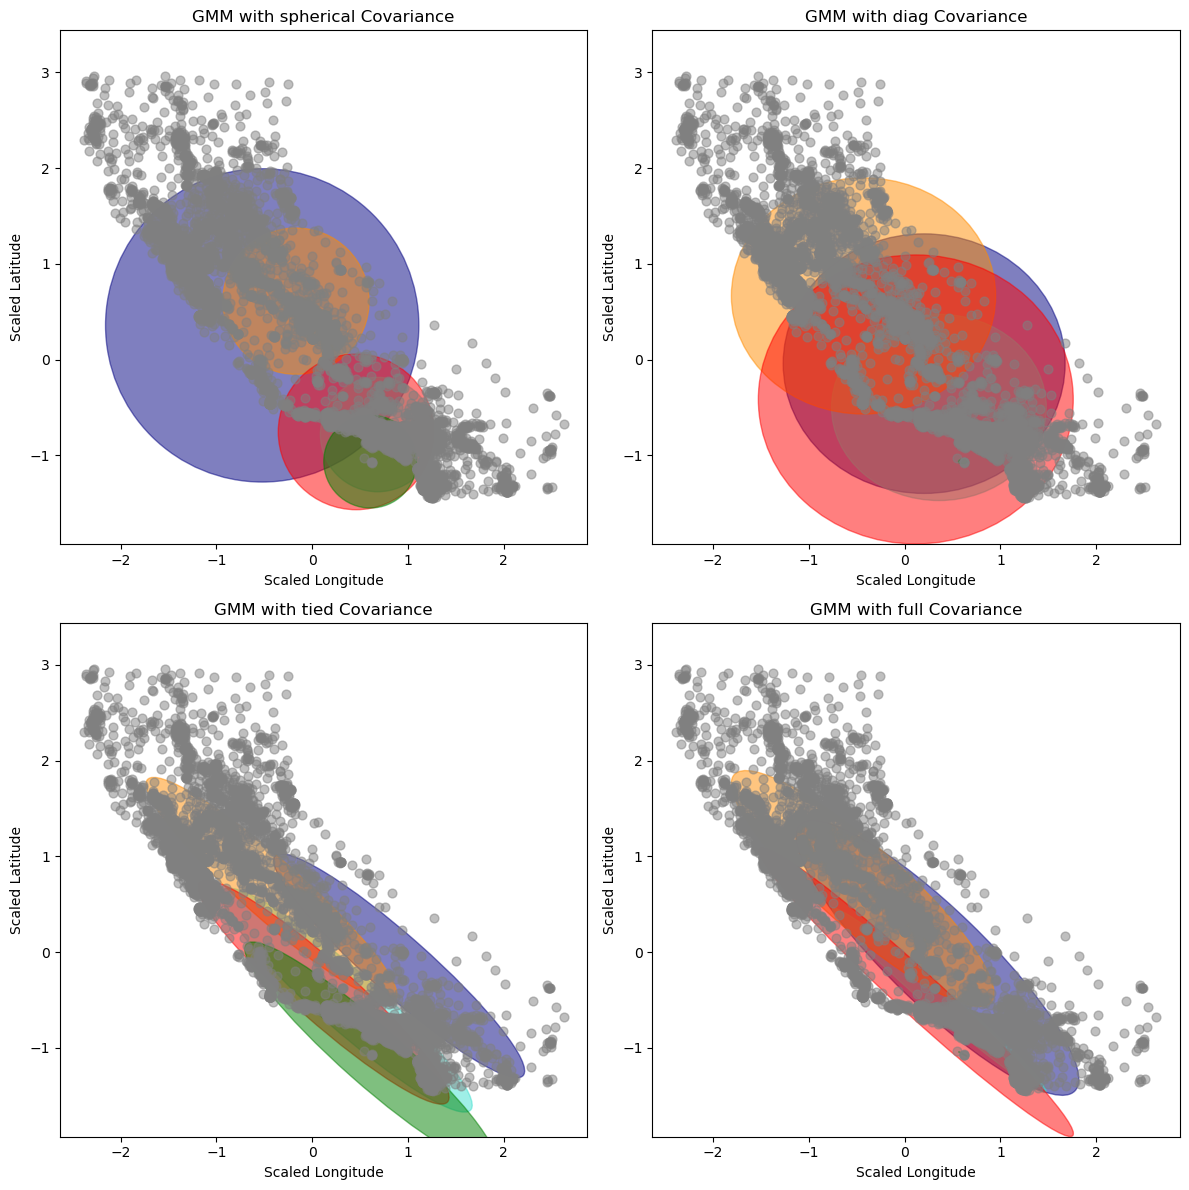

In [3]:
def draw_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], width=v[0], height=v[1], angle=180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


covariance_types = ['spherical', 'diag', 'tied', 'full']
n_classes = 5
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for n, cov_type in enumerate(covariance_types):
    gmm = GaussianMixture(n_components=n_classes, covariance_type=cov_type, max_iter=100, random_state=0)
    gmm.fit(housing_scaled)
    
    ax = axs[n]
    draw_ellipses(gmm, ax)
    ax.scatter(housing_scaled[:, 0], housing_scaled[:, 1], s=40, color='gray', alpha=0.5)
    ax.set_title(f'GMM with {cov_type} Covariance')
    ax.set_xlabel('Scaled Longitude')
    ax.set_ylabel('Scaled Latitude')

plt.tight_layout()
plt.show()

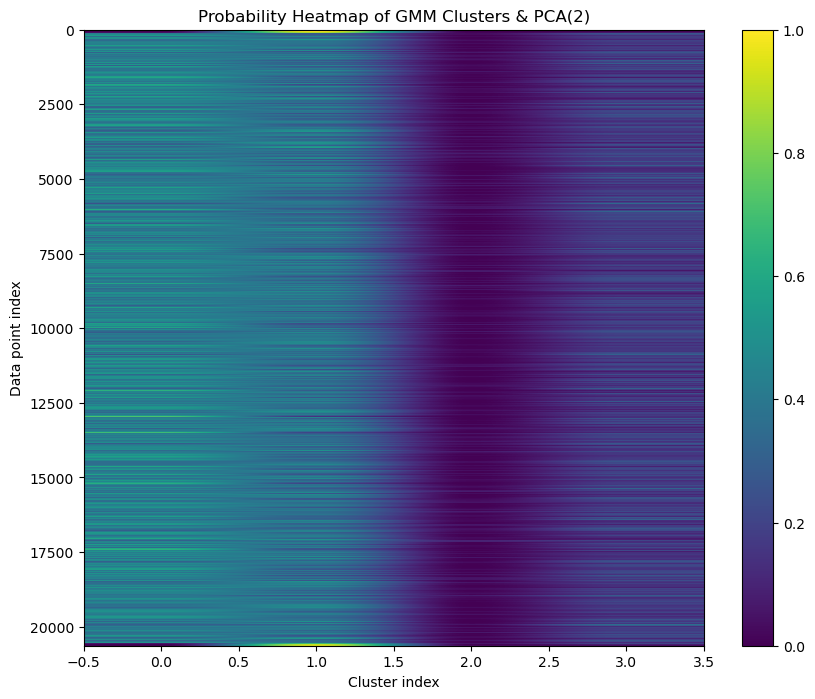

In [4]:
pca = PCA(n_components=2)
housing_pca = pca.fit_transform(housing_scaled)

gmm = GaussianMixture(n_components=4, covariance_type='spherical', random_state=42)
gmm.fit(housing_pca)

probabilities = gmm.predict_proba(housing_pca)

plt.figure(figsize=(10, 8))
plt.imshow(probabilities, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Probability Heatmap of GMM Clusters & PCA(2)')
plt.ylabel('Data point index')
plt.xlabel('Cluster index')
plt.show()

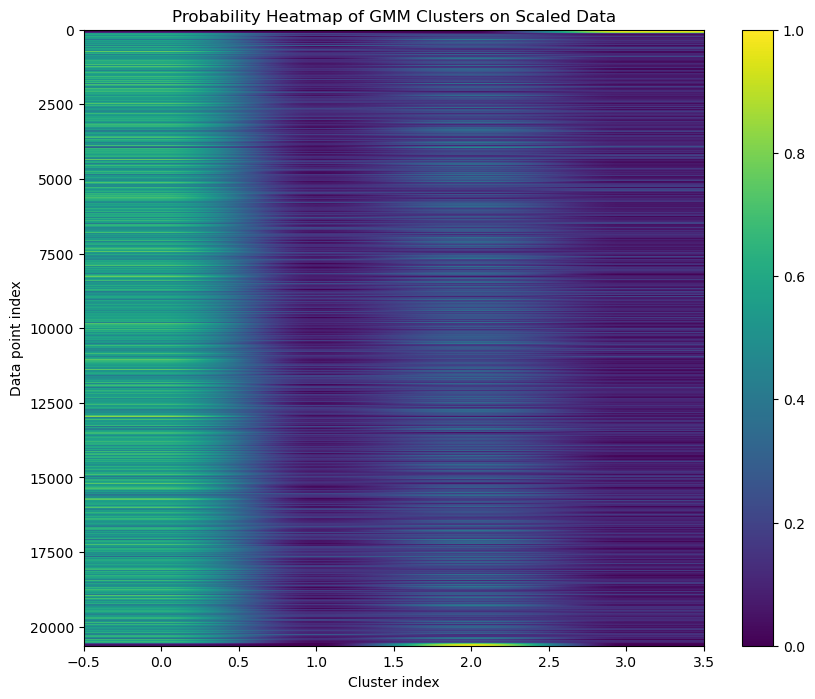

In [5]:
gmm = GaussianMixture(n_components=4, covariance_type='spherical', random_state=42)
gmm.fit(housing_scaled)

probabilities = gmm.predict_proba(housing_scaled)

plt.figure(figsize=(10, 8))
plt.imshow(probabilities, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Probability Heatmap of GMM Clusters on Scaled Data')
plt.ylabel('Data point index')
plt.xlabel('Cluster index')
plt.show()

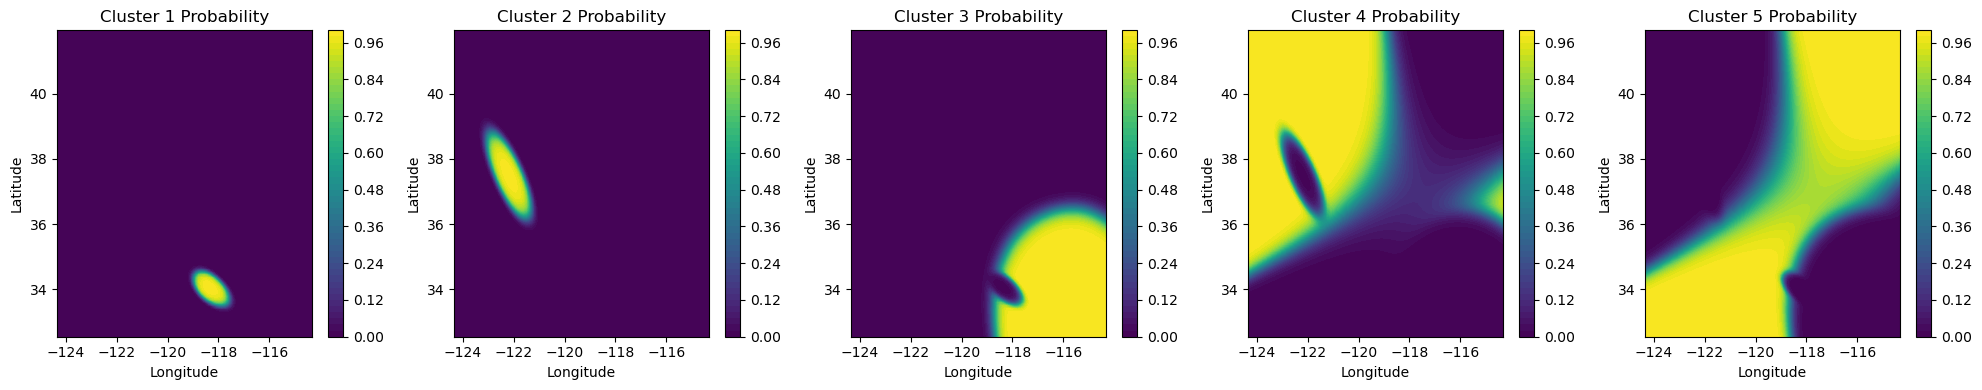

In [6]:
geo_data = housing[['longitude', 'latitude']]

gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm.fit(geo_data)

x = np.linspace(geo_data['longitude'].min(), geo_data['longitude'].max(), 100)
y = np.linspace(geo_data['latitude'].min(), geo_data['latitude'].max(), 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

geo_grid = pd.DataFrame(XX, columns=['longitude', 'latitude'])

Z = gmm.predict_proba(geo_grid)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    Z_reshape = Z[:, i].reshape(X.shape)
    cs = axs[i].contourf(X, Y, Z_reshape, cmap='viridis', levels=50)
    fig.colorbar(cs, ax=axs[i], orientation='vertical')
    axs[i].set_title(f'Cluster {i+1} Probability')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].set_aspect('auto')

plt.tight_layout()
plt.show()

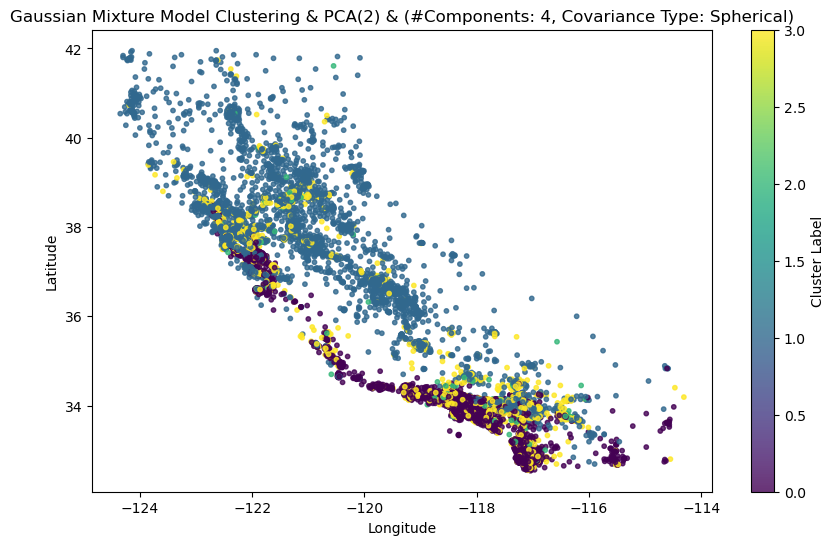

In [7]:
pca = PCA(n_components=2)
housing_pca = pca.fit_transform(housing_scaled)

gmm = GaussianMixture(n_components=4, covariance_type='spherical', random_state=42)
gmm.fit(housing_pca)

cluster_labels = gmm.predict(housing_pca)

plt.figure(figsize=(10, 6))
plt.scatter(housing['longitude'], housing['latitude'], c=cluster_labels, cmap='viridis', s=10, alpha=0.8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Gaussian Mixture Model Clustering & PCA(2) & (#Components: 4, Covariance Type: Spherical)')
plt.show()

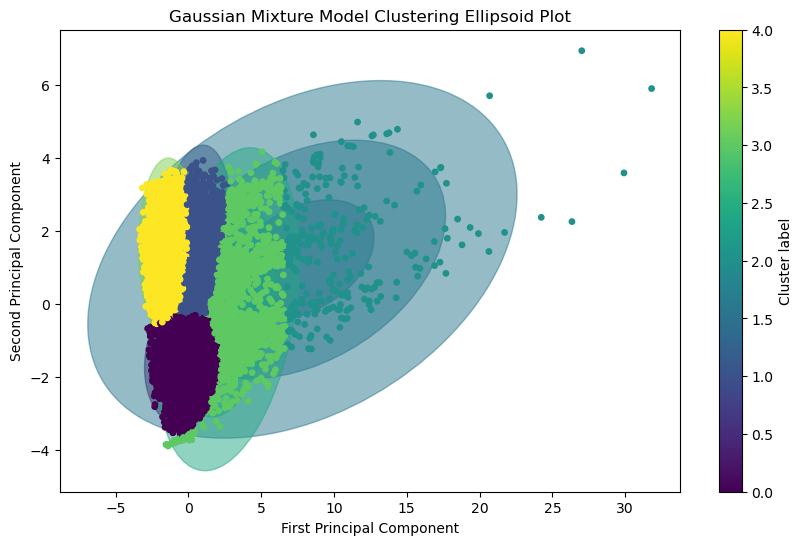

In [8]:
pca = PCA(n_components=2)
housing_pca = pca.fit_transform(housing_scaled)

gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm.fit(housing_pca)
cluster_labels = gmm.predict(housing_pca)

def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width = height = 2 * np.sqrt(covariance)

    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))


plt.figure(figsize=(10, 6))
ax = plt.gca()

for pos, covar, label in zip(gmm.means_, gmm.covariances_, range(gmm.n_components)):
    draw_ellipse(pos, covar, ax, alpha=0.5, color=plt.cm.viridis(label / gmm.n_components))

plt.scatter(housing_pca[:, 0], housing_pca[:, 1], c=cluster_labels, cmap='viridis', s=15)
plt.title('Gaussian Mixture Model Clustering Ellipsoid Plot')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster label')
plt.show()